In [1]:
# Mount google drive :

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Unzip the dataset and save it to the path "/content/imagedb_btsd" :
import os
import zipfile

local_zip = '/content/drive/MyDrive/cv_proj_4_dataset/imagedb_btsd.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/imagedb_btsd')
zip_ref.close()

In [3]:
# Select the folder "imagedb" as the training folder
# and the folder "imagedb_test" as the testing folder :

base_dir = '/content/imagedb_btsd'

train_dir = os.path.join(base_dir, 'imagedb')
test_dir = os.path.join(base_dir, 'imagedb_test')

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from keras import optimizers


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(256, 256, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(34, activation='softmax'))

model.compile(optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                    

In [5]:
# check this :

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f6ebf804650> True
<keras.layers.convolutional.Conv2D object at 0x7f6e4a93d250> True
<keras.layers.pooling.MaxPooling2D object at 0x7f6e404eb810> True
<keras.layers.convolutional.Conv2D object at 0x7f6e404fe390> True
<keras.layers.convolutional.Conv2D object at 0x7f6e40506a10> True
<keras.layers.pooling.MaxPooling2D object at 0x7f6e404fc550> True
<keras.layers.core.flatten.Flatten object at 0x7f6e40492c90> True
<keras.layers.core.dense.Dense object at 0x7f6e404fe1d0> True
<keras.layers.core.dropout.Dropout object at 0x7f6e4050fbd0> True
<keras.layers.core.dense.Dense object at 0x7f6e4053c2d0> True


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 90,
                                  horizontal_flip=True,
                                  vertical_flip = True,
                                   brightness_range=[0.2,1.0],
                                   zoom_range=[0.5,1.0],                                   
                                   validation_split=0.2)
                                  #  preprocessing_function = preprocess_func)
                                  
#train_datagen  = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --------------------
# Flow training images in batches using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=40,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(256,256),
                                                    shuffle=True,
                                                    subset='training', seed=1)     
# --------------------
# Flow validation images in batches using test_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                          batch_size=40,
                                                          class_mode='categorical',
                                                          # color_mode='grayscale',
                                                          target_size=(256,256),
                                                          subset='validation', seed=1)


Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.


In [7]:
# Apply callbacks :

import datetime 
import tensorflow as tf
  
my_callbacks = []

# logdir = os.path.join("/content/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# my_callbacks.append(tensorboard_callback)

save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'model_from_scratch_best.hdf5', save_best_only=True, verbose=1)
my_callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
my_callbacks.append(early_stop_callback)

In [8]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              # steps_per_epoch=50,
                              steps_per_epoch=train_generator.samples/train_generator.batch_size,
                              epochs=30,
                              validation_steps=15,
                              verbose=1,
                              callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
62/61 [==============================] - ETA: 0s - loss: 82.0111 - accuracy: 0.1372
Epoch 00001: val_loss improved from inf to 2.60324, saving model to model_from_scratch_best.hdf5
61/61 [==============================] - 109s 2s/step - loss: 82.0111 - accuracy: 0.1372 - val_loss: 2.6032 - val_accuracy: 0.2905
Epoch 2/30
62/61 [==============================] - ETA: 0s - loss: 2.7107 - accuracy: 0.2731
Epoch 00002: val_loss improved from 2.60324 to 2.26780, saving model to model_from_scratch_best.hdf5
61/61 [==============================] - 91s 1s/step - loss: 2.7107 - accuracy: 0.2731 - val_loss: 2.2678 - val_accuracy: 0.4090
Epoch 3/30
62/61 [==============================] - ETA: 0s - loss: 2.3847 - accuracy: 0.3606
Epoch 00003: val_loss improved from 2.26780 to 1.93003, saving model to model_from_scratch_best.hdf5
61/61 [==============================] - 90s 1s/step - loss: 2.3847 - accuracy: 0.3606 - val_loss: 1.9300 - val_accuracy: 0.5275
Epoch 4/30
62/61 [===========

In [9]:
# test_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator()
# --------------------
# Flow testing images in batches using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=10,
                                                   class_mode='categorical',
                                                  #  color_mode='grayscale',
                                                   target_size=(256,256))
# # Testing the CNN on testing data : 
# loss, acc = model.evaluate(test_generator)

Found 2149 images belonging to 34 classes.


215/215 [==============================] - 6s 28ms/step - loss: 1.5039 - accuracy: 0.6636


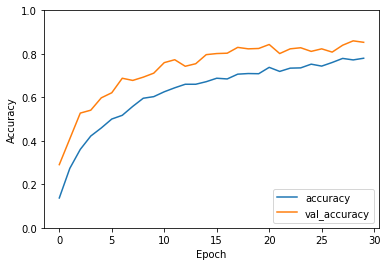

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Testing the CNN on testing data : 
loss, acc = model.evaluate(test_generator)